In [1]:
import numpy as np

In [2]:
def phi(U,a,b,c,e,f):
    try:
        u = U[:,0]
        v = U[:,1]
    except IndexError:
        u = U[0]
        v = U[1]
    return np.exp((a*v**2 + b*u**2 - c*u*v)/(4.*a*b-c**2) -2*np.pi*1j*(f*v+e*u))

def psi(x,y, a, b, c, e, f):
    invSigma = np.array([[-2.0*a,-c],[-c, -2.0*b]])
    if not isinstance(x,np.ndarray):
        xx = np.array([x-e,y-f])
    else:
        xx = np.stack([x-e,y-f], axis = 1).T
    
    return np.exp(-1./2*xx.T.dot(invSigma).dot(xx))

def phi_old(u, v, l, Cx, Cy):
    return np.exp(-1.0/2.0 * (u * u + v * v) * l * l) * np.exp(1j*(Cx * u + Cy * v))

In [3]:
mycmap = 'inferno'

In [4]:
x = np.arange(100)
y = np.arange(100)
print('Image size x: %i\nImage size y: %i' % (x.shape[0], y.shape[0]))
u = (x-x.shape[0]/2.0)/(x.shape[0])
v = (y-y.shape[0]/2.0)/(y.shape[0])

Image size x: 100
Image size y: 100


In [5]:
factor = 1.5
s1 = 20
s2 = 20
s12 = 10

a = -1./2*s2/(s1*s2-s12**2)
b = -1./2*s1/(s1*s2-s12**2)
c = s12/(s1*s2-s12**2)
invSigma = np.array([[-2.*a,-c],[-c, -2.*b]])
print(np.linalg.inv(invSigma))

e = x.shape[0]/2
f = y.shape[0]/2
img = np.zeros((x.shape[0],y.shape[0]))

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        img[i,j] = psi(x[i],y[j],a,b,c,e,f)

[[ 20.  10.]
 [ 10.  20.]]


In [6]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

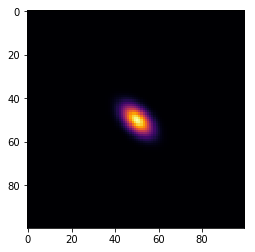

In [7]:
plt.imshow(img, cmap = mycmap)
IMAGE_SIZE_X, IMAGE_SIZE_Y = img.shape

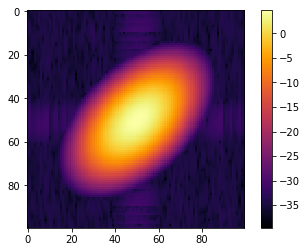

In [8]:
img_fft= np.fft.fft2(img)
FTgshift = np.fft.fftshift(img_fft)

plt.imshow(np.log(np.abs(FTgshift)), cmap=mycmap)
plt.colorbar()

In [9]:
FTgmodel = np.zeros((u.shape[0],v.shape[0]), dtype=np.complex)
for i in range(u.shape[0]):
    for j in range(v.shape[0]):
#         print(i,u[i],j,v[j])
        U = np.array([u[i],v[j]])
        FTgmodel[i,j] = phi(U,a,b,c,e,f)
#         FTgmodel[i,j] = phi_old(u[i],v[j],np.sqrt(s1),e,f)

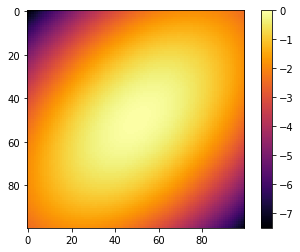

In [10]:
plt.imshow(np.log(np.abs(FTgmodel)+10e-350), cmap = mycmap)
plt.colorbar()

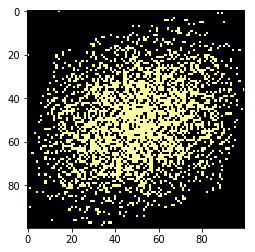

In [11]:
from masking import *

## Parameters
B_max = 1
antennas = 60
typeArray = 'URA'
sigma = B_max/6.0

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
plt.imshow(np.fft.fftshift(mask), cmap = mycmap)

Percentage of measurements: 25.23


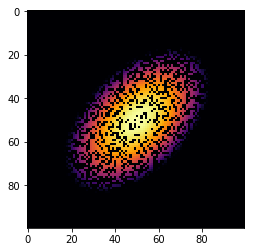

In [12]:
measurements,U,V = UVCreator(img_fft,mask)

measurements_abs = np.log(np.abs(measurements)+1e-12)
plt.imshow(np.fft.fftshift(measurements_abs), cmap=mycmap)

p = 100*U.shape[0]/(measurements.shape[0]*measurements.shape[1]) 
print('Percentage of measurements: %s' % p)

# Inference on Edward

In [13]:
import edward as ed
import tensorflow as tf

from edward.models import Normal, WishartCholesky, MultivariateNormalFullCovariance

In [14]:
def tf_phi(U,a,b,c,e,f):
    u = tf.cast(U[:,0,np.newaxis], tf.float32)
    v = tf.cast(U[:,1,np.newaxis], tf.float32)
    
    A = tf.exp(tf.divide(tf.matmul(a,tf.pow(v,2), name='av2', transpose_b=True) + tf.matmul(b,tf.pow(u,2), name='bu2', transpose_b=True) - tf.matmul(c,tf.multiply(u,v), name='cuv',transpose_b=True), 4.*tf.multiply(a,b)-tf.multiply(c,c)))
    sinPart = tf.cast(tf.sin(-2.0*np.pi*(tf.matmul(f,v, transpose_b=True)+tf.matmul(e,u, transpose_b=True))), tf.float32)
    cosPart = tf.cast(tf.cos(-2.0*np.pi*(tf.matmul(f,v, transpose_b=True)+tf.matmul(e,u, transpose_b=True))), tf.float32)
    return A*cosPart, A*sinPart

def visibility_model(U,alpha,a,b,c,e,f, factor = None, IMAGE_SIZE_X = IMAGE_SIZE_X, IMAGE_SIZE_Y = IMAGE_SIZE_Y):
    
    realPart, imagPart = tf_phi(U,a,b,c,e,f)
    
    return tf.stack([tf.reduce_sum(tf.multiply(alpha,realPart), axis=0), tf.reduce_sum(tf.multiply(alpha,imagPart), axis=0)], axis = 1)

In [17]:
print('******** Probabilistic Model *********')
numberOfSamplings = U.shape[0]
numberOfBasis = 10
print('Number of Samplings: {}'.format(numberOfSamplings))
print('Number of Basis    : {}'.format(numberOfBasis))
print('***Priors***')

alpha_s = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([], dtype=tf.float32))))
alpha_model = Normal(loc=tf.zeros((numberOfBasis,1)),
                     scale=7.0*tf.ones((numberOfBasis,1)) )
print('alpha: {}'.format(alpha_model))

s1_model = Normal(loc=tf.zeros((numberOfBasis,1)),
                     scale=tf.ones((numberOfBasis,1)) )
s2_model = Normal(loc=tf.zeros((numberOfBasis,1)),
                     scale=tf.ones((numberOfBasis,1)) )
s12_model = Normal(loc=tf.zeros((numberOfBasis,1)),
                     scale=tf.ones((numberOfBasis,1)) )
print('s\u2081   : {}'.format(s1_model))
print('s\u2082   : {}'.format(s2_model))
print('s\u2081\u2082  : {}'.format(s12_model))

a_model = -1./2*s2_model/(s1_model*s2_model-tf.multiply(s12_model,s12_model))
b_model = -1./2*s1_model/(s1_model*s2_model-tf.multiply(s12_model,s12_model))
c_model = s12_model/(s1_model*s2_model-tf.multiply(s12_model,s12_model))

e_model = Normal(loc=x.shape[0]/2.0 * tf.ones((numberOfBasis,1)), scale = 20.0* tf.ones((numberOfBasis,1)))
f_model = Normal(loc=y.shape[0]/2.0 * tf.ones((numberOfBasis,1)), scale = 20.0* tf.ones((numberOfBasis,1)))
print('Cx   : {}'.format(e_model))
print('Cy   : {}'.format(f_model))

U_ph = tf.placeholder(tf.float32, shape=U.shape)
V_model = visibility_model(U_ph,alpha_model,a_model,b_model,c_model,e_model,f_model)

df = tf.constant(5.0, dtype=tf.float32)
init_chol = tf.constant(np.array([[0.01,0.001],[0.001,0.01]]), dtype=tf.float32)
chol_scale = tf.cholesky(init_chol)
Sigma = WishartCholesky(df=df, scale=chol_scale)

Vobs = MultivariateNormalFullCovariance(loc=V_model,
           covariance_matrix=Sigma)
print('***Model***')
print('V_obs: {}'.format(Vobs))

******** Probabilistic Model *********
Number of Samplings: 2523
Number of Basis    : 10
***Priors***
alpha: RandomVariable("Normal_6/", shape=(10, 1), dtype=float32)
s₁   : RandomVariable("Normal_7/", shape=(10, 1), dtype=float32)
s₂   : RandomVariable("Normal_8/", shape=(10, 1), dtype=float32)
s₁₂  : RandomVariable("Normal_9/", shape=(10, 1), dtype=float32)
Cx   : RandomVariable("Normal_10/", shape=(10, 1), dtype=float32)
Cy   : RandomVariable("Normal_11/", shape=(10, 1), dtype=float32)
***Model***
V_obs: RandomVariable("MultivariateNormalTriL", shape=(2523, 2), dtype=float32)


In [ ]:
inference = ed.MAP(data={Vobs: V})
optimizer = tf.train.AdamOptimizer(5e-3)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

sess = ed.get_session()
tf.global_variables_initializer().run()

In [16]:
n_epoch = 1000
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
    info_dict = inference.update(feed_dict={U_ph: X_train, y_ph: y_train})
    train_loss[i] = info_dict['loss']
    test_loss[i] = sess.run(inference.loss, feed_dict={X_ph: X_test, y_ph: y_test})
    inference.print_progress(info_dict)

NameError: name 'inference' is not defined

In [ ]:
U